<head style = "position:absolute; left:0px" class = "lse_header">
    <div style="width: 15%; float:left; height:100px;">
        <img src = "https://www.dropbox.com/s/mz416p4rrm692ed/lse_logo.png?raw=1" style="width: 100px; height: 35px; float:left; margin-top: 30px">
    </div>
    <div style="width: 70%; float:left; height:100px;">
        <h4 style = "text-align:center;margin-top: 30px;">FM442: Quantitative Methods for Finance and Risk Analysis</h4>
    </div>
    <div style="width: 15%; float:left; height:100px;">
        <p style = "text-align:right;margin-top:30px">Jon Danielsson<br>
    Michaelmas Term 2020</p>
    </div>
</head>

<h1 style = "text-align: center; font-size: 36px">Seminar 5</h1>

In this class we will:  

[1. Introduce multivariate volatility models](#1)  
[2. Build a bivariate EWMA model](#2)  
[3. Run DCC models with different specifications](#3)    
[4. Compare models](#4)  

___
### Loading packages

We first load the packages for this seminar:

In [2]:
library(rmgarch)
library(microbenchmark)
library(lubridate)

___
<a name="1"></a>
## Multivariate volatility models

In a univariate volatility model, we consider a stock with returns $Y_t$ that can be written as:

$$Y_t = \sigma_{t} Z_{t}$$

Where $\sigma_t$ is the conditional volatility and $Z_t$ are random shocks.

For many financial applications, we have to consider a vector of assets, instead of a single asset. So, if we have $K>1$ assets, it is necessary to indeicate which asset and paremeters are being referred to. The notation we will use is:

$$Y_{t,i} = \sigma_{t,i} Z_{t,i}$$

Where the first subscript indicates the date, and the second subscript the asset.

Now our conditional covariance is a symmetric square conditional covariance matrix, where the dimension is the number of assets. For example, for three assets it would be:

$$
\begin{equation*}
\Sigma_{t} = 
\begin{pmatrix}
\sigma_{t,11} & &  \\
\sigma_{t,12} & \sigma_{t,22} & \\
\sigma_{t,13} & \sigma_{t,23} & \sigma_{t,33} 
\end{pmatrix}
\end{equation*}
$$

If we have a portfolio wight a vector $w$ of portfolio weights, then the portfolio variance would be:

$$\sigma^2_{\textrm{portfolio}} = w'\Sigma w$$

As in the case of univariate models, we need to ensure that the variance is not negative. In this case, this means that the covariance matrix $\Sigma$ is positive semi-definite:

$$ |\Sigma| \geq 0$$

Working with several assets presents the _curse of dimensionality_. This means that the number of variance and covariance terms will explode as the number of assets increase, which makes it challenging to estimate the covariance matrix and ensure its positive semi-definiteness.

For example, if we try to estimate a GARCH model for two assets, we would have 21 parameters to estimate, which is almost impossible in practice. 

The concept of _stationarity_ is more important in multivariate volatility models, since violating it could lead to numerical problems. In this seminar we will focus in implementing three different multivariate models:

* Exponentially-Weighted Moving Average
* Dynamic Conditional Correlation Models
* Orthogonal-GARCH

To do so, we will work with the returns from JP Morgan and Citigroup.

In [3]:
# Load the data
load("Y.RData")

# Extract the returns for JPM and C
y <- Y[c("JPM", "C")]

___
<a name="2"></a>
## EWMA

In the Exponentially-Weighted Moving Average model, the estimated conditional volatility at time $t$ is a convex combination of the estimation at time $t-1$ and the squared returns at time $t-1$. In general, if we have a vector of returns for each time $t$ that includes all assets $K$: 

$$\textbf{y}_{t} = [y_{t,1}, y_{t,2}, \ldots, y_{t,K}]$$

Then the multivariate EWMA is:

$$\hat{\Sigma}_{t} = \lambda \hat{\Sigma}_{t-1} + (1-\lambda) \textbf{y}'_{t-1} \textbf{y}_{t-1}$$

The properties of this mdoel are:
* The same pre-specified weight, $\lambda$ is used for all assets
* The variance of any particular asset only depends on its own lags

### Implementation

Since we will perform linear algebra operations to compute the EWMA, it is more convenient to work with a matrix instead of a dataframe, so let's first turn y from a dataframe into a matrix:

In [4]:
# Check the class of y
class(y)

# Transform into matrix
y  <- as.matrix(y)

# Check class again
class(y)

[1] "data.frame"

[1] "matrix"

Let's take a look at the returns:

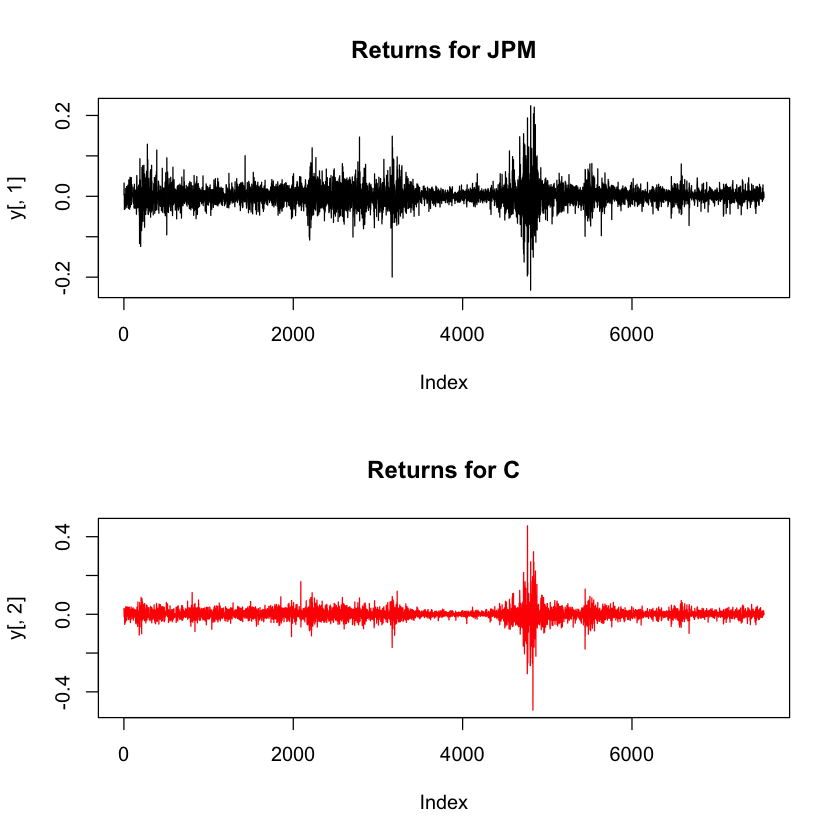

In [5]:
# Plotting the returns in a 2x1 grid
par(mfrow = c(2,1))
plot(y[,1], type = "l", main = "Returns for JPM", col = 1)
plot(y[,2], type = "l", main = "Returns for C", col = 2)
# Reset the grid
par(mfrow = c(1,1))

We will create a `EWMA` matrix that will hold our estimations for the elements of $\Sigma$. First let's establish the number of entries the matrix should have:

In [6]:
# Determine number of entries
n <- dim(y)[1]

Now we create the matrix. We could initialize the matrix with a number, like 0, but it is recommended to initialize it with `NA` to avoid any potential mistakes.

To determine the number of columns in the matrix, we need to figure out how many parameters we are estimating in every time period. For any given time $t$, we will be estimating the conditional variance of each asset, and the conditional covariances. For $K$ assets, this is:

$$K + K(K-1)/2$$

In our case, it is 3. Column 1 will hold the conditional variance of JPM, column 2 will hold the conditional covariance between JPM and C, and column 3 will hold the conditional variance for Citigroup:

In [7]:
# Initializing the EWMA matrix
EWMA <- matrix(NA, nrow = n, ncol = 3)

#### Why do we initialize a matrix/vector?

It is convenient to create the vector or matrix we want to populate before doing so for two reasons:

1. Good programming practice. It is better to have a fixed-length object than to re-size an object in every iteration of the loop.
2. Be able to spot mistakes. In case there is an error in your loop and try to allocate an element to a non-existing row, you will get an error message. If you are dynamically modifying the size of the object, you can add more rows/columns by accident without realizing it

We could fill the new matrix with any values, and it is common to fill them with zeros. However, it is useful to fill the matrix with `NA`. This way, if something in the loop doesn't work, out matrix will have some empty spots instead of holding zeros, and whenever we try to make any operation we will get an error message.

We determine the value for $\lambda$:

In [8]:
# Determine lambda
lambda <- 0.94

A common problem is to determine how to estimate the conditional covariances of the first period. In other words, how do we estimate $\hat{\Sigma}_1$ without $\hat{\Sigma}_0$ or $\textbf{y}_0$. For this, we will use the unconditional covariance of the sample and "burn" the first few observations. The effect of a given conditional covariance from a past period quickly dies out as time passes, because $\lambda^n \rightarrow 0$ as $n \rightarrow \infty$, so the effect of initializing the EWMA matrix with the unconditional covariance will not be a problem after a few time periods. A rule of thumb is to burn the first 30 observations.

In [9]:
# Get the sample covariance
S <- cov(y)
S

,JPM,C
JPM,0.0005487714,0.0004345622
C,0.0004345622,0.0007748630


We want to get the three unique values of the matrix. This can be done in three different ways shown below. We recommend using the last, since it is easily reproducible for any number of assets:

In [10]:
# Getting the unique values in three ways:

# 1. Creating a vector with the distinct elements
c(S[1,1], S[1,2], S[2,2])

# 2. Vectorizing the matrix and getting distinct elements
c(S)[c(1,2,4)]

# 3. Using the fact that S is symmetric and using upper.tri()/lower.tri()
S[!upper.tri(S)]

[1] 0.0005487714 0.0004345622 0.0007748630

[1] 0.0005487714 0.0004345622 0.0007748630

[1] 0.0005487714 0.0004345622 0.0007748630

In [11]:
# Fill the initial row of EWMA with the sample covariances
EWMA[1,] <- S[!upper.tri(S)]

# View the matrix
head(EWMA)

0.0005487714,0.0004345622,0.000774863
NA,NA,NA
NA,NA,NA
NA,NA,NA
NA,NA,NA
NA,NA,NA


The first column is the sample variance of JPM, the second column is the sample covariance, and the third column is the sample variance of C.

As an example, let's manually compute how we would estimate the variances and covariance for $t=2$:

In [12]:
# Manually computing EWMA elements for t = 2

# Apply the formula for EWMA
S_2 <- lambda * S + (1-lambda) * y[1,] %*% t(y[1,])
# Get the variances and covariances
S_2[!upper.tri(S_2)]

[1] 0.0005168911 0.0004160641 0.0007832391

Now that we have seen how to get the elements for a given time, we can write a _for_ loop to populate the entire `EWMA` matrix:

In [13]:
# Populating the EWMA matrix

# Create a loop for rows 2 to n
for (i in 2:n) {
    # Update S with the new weighted moving average
    S <- lambda * S + (1-lambda) * y[i-1,] %*% t(y[i-1,])
    
    # Fill the following EWMA row with the covariances
    EWMA[i,] <- S[!upper.tri(S)]
}

Let's see the `head()` of our `EWMA` matrix:

In [14]:
head(EWMA)

0.0005487714,0.0004345622,0.0007748630
0.0005168911,0.0004160641,0.0007832391
0.0005503867,0.0004160567,0.0007458997
0.0005183350,0.0003880307,0.0007108004
0.0004881988,0.0003667869,0.0006724619
0.0004589068,0.0003447797,0.0006363514


### Important note on Matrix Operations

Since we are working with matrices, it is **very important** to pay attention to the dimensions of the elements, to make sure we don't do any mistake when multiplying vectors. Here is a short review on the order of vectors for multiplication:

In [15]:
# Matrix operations - The order is important

# This is a 2x1 vector
y[1,]

# This is a scalar
t(y[1,]) %*% y[1,]

# This is a matrix
y[1,] %*% t(y[1,])

JPM           C 
0.004175271 0.030240123

0.000931898


JPM,C
1.743289e-05,0.0001262607
1.262607e-04,0.0009144651


Let's create a `wrong_EWMA` matrix to show what would happen if we were to mix up the transposes:

In [16]:
# Creating a wrong EWMA

# Initialize the matrix the same way
wrong_EWMA <- matrix(NA, nrow = n, ncol = 3)
S <- cov(y)
wrong_EWMA[1,] <- S[!upper.tri(S)]

# Do the loop but interchange the transpose
for (i in 2:n) {
    # Update S with the new weighted moving average
    S <- lambda * S + (1-lambda) * t(y[i-1,]) %*% y[i-1,]
    
    # Fill the following EWMA row with the covariances
    wrong_EWMA[i,] <- S[!upper.tri(S)]
}

ERROR: Error in lambda * S + (1 - lambda) * t(y[i - 1, ]) %*% y[i - 1, ]: non-conformable arrays


### Plotting the conditional variances and covariances

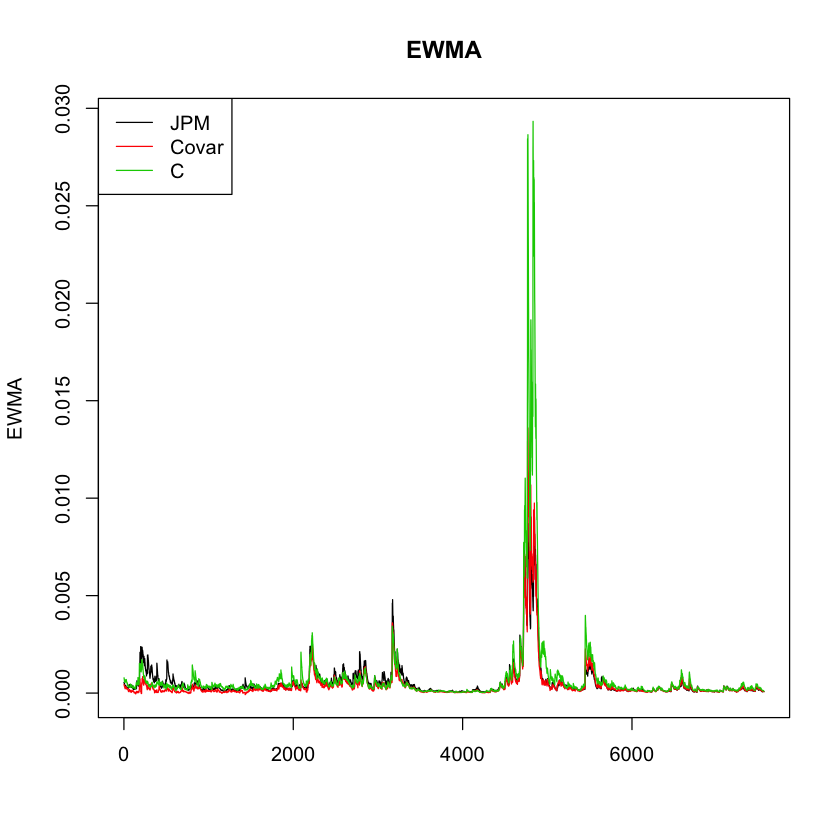

In [17]:
# Plotting estimated variances and covariances
matplot(EWMA, type = "l", main = "EWMA", lty = 1)
legend("topleft", legend = c("JPM", "Covar", "C"), col = 1:3, lty = 1)

We can calculate the correlation coefficient of the two stocks, which is the covariance over the square root of variances:

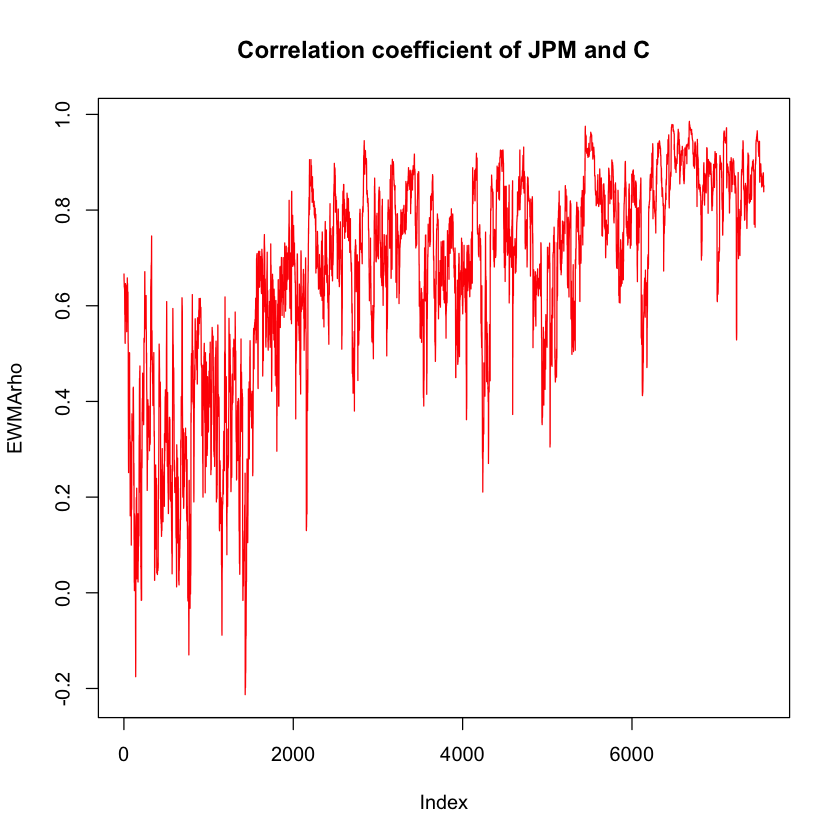

In [18]:
# Correlation coefficient
EWMArho <- EWMA[,2]/sqrt(EWMA[,1]*EWMA[,3])

# Plot
plot(EWMArho, type = "l", main = "Correlation coefficient of JPM and C", col = "red")

Let's replicate the plots including the date as the x-axis. We can get it from our `Y` data frame:

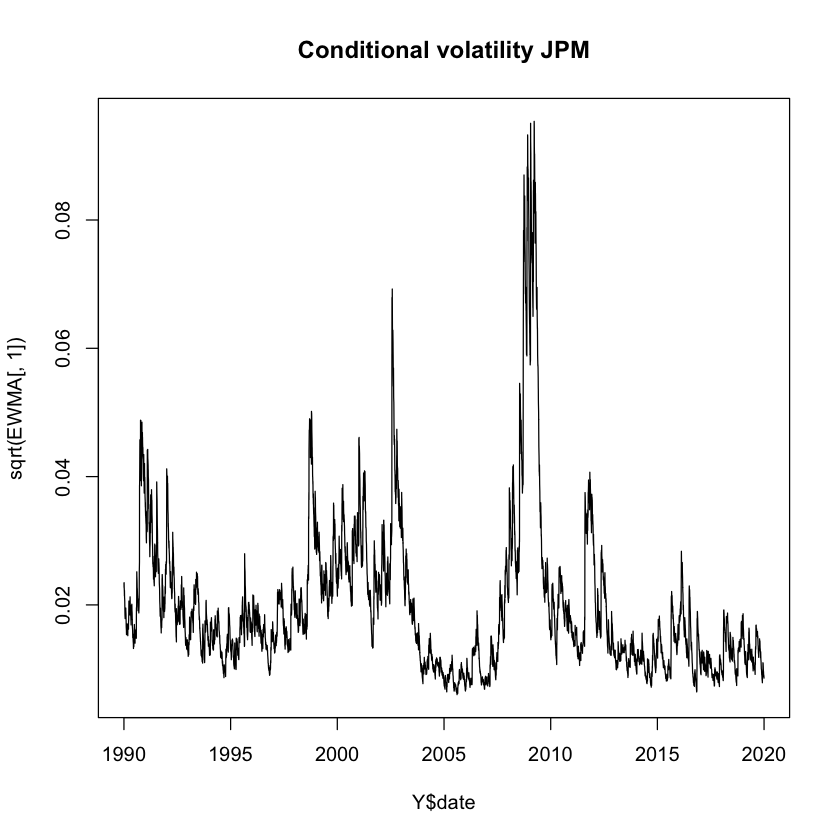

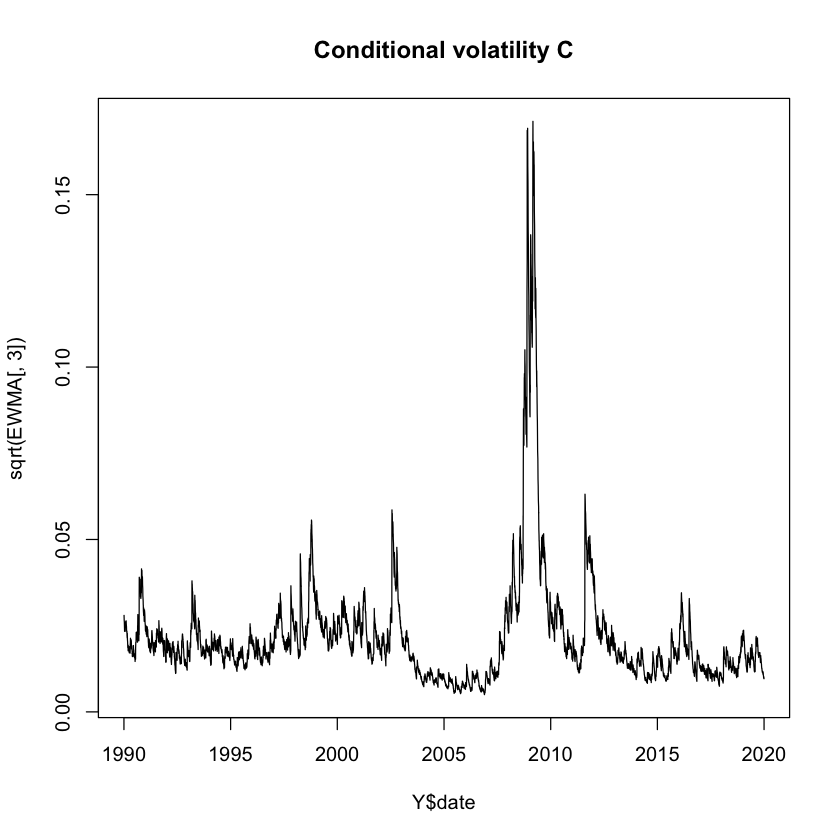

In [19]:
# Plots for conditional volatility
plot(Y$date, sqrt(EWMA[,1]), type = "l", main = "Conditional volatility JPM")
plot(Y$date, sqrt(EWMA[,3]), type = "l", main = "Conditional volatility C")

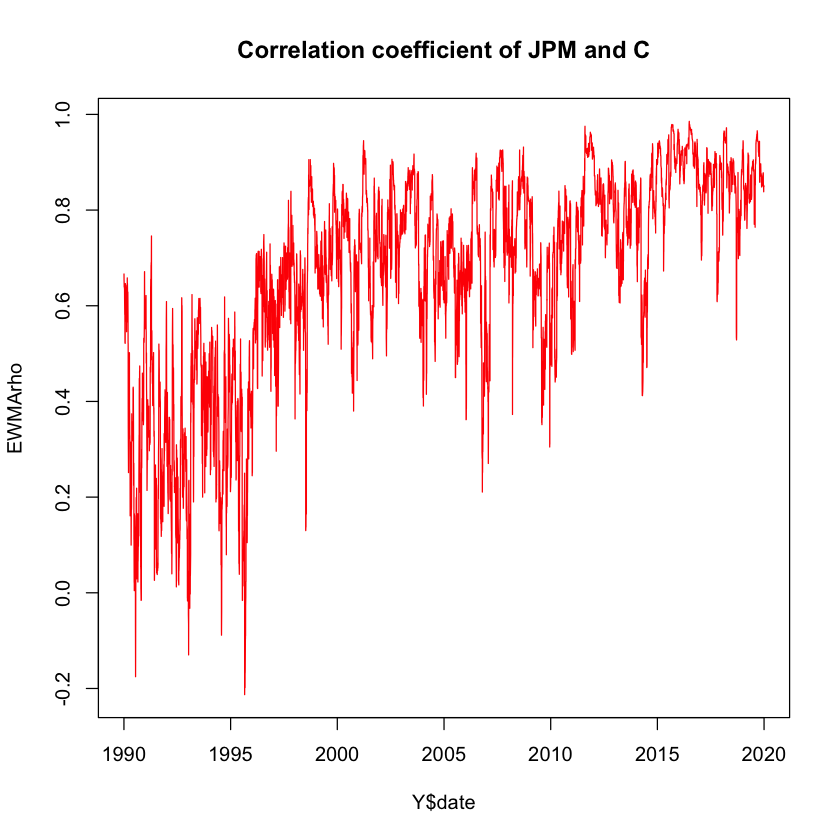

In [20]:
# Correlation Coefficient plot
plot(Y$date, EWMArho, type = "l", main = "Correlation coefficient of JPM and C", col = "red")

___
<a name="3"></a>
## Dynamic Conditional Correlation models

To discuss and implement Dynamic Conditional Correlation (DCC) models, we first have to discuss Constant Conditional Correlation (CCC) models. In this type of model, we separate out correlation modeling from volatility model. For the former, we use a correlation matrix, and for the latter we use GARCH or some standard method.

To estimate the volatiliies, let $D_t$ be a diagonal matrix where each element is the _volatility_ of each asset:

$$D_{t,ii} = \sigma_{t,i}, \hspace{0.5cm} i = 1, ..., K$$
$$D_{t,ij} = 0, \hspace{0.5cm} i\neq j$$

We can use univariate GARCH to estimate the variance of each asset separately. To get $D_t$:

$$D_{t,ii} = \sigma_{t,i} = \sqrt{\omega_i + \alpha_i y^2_{t-1} + \beta_i \sigma^2_{t-1,i}}, \hspace{0.5cm} i = 1, ... ,K$$

To estimate the correlations, consider:

$$\underset{K\times 1}{\epsilon_t} := D_t^{-1} \textbf{y}_t$$

And:

$$\underset{T \times K}{\epsilon}$$

The distinction between CCC and DCC comes from how to construct the type of correlation matrix from $\epsilon$. In CCC models we use a _static_ matrix $R$:

$$\hat{R} := \textrm{Cov}(\epsilon)$$


The DCC, on the other hand, introduces a time-dependent correlation matrix $R_t$ that is composed of the quadratic form:

$$R_t = Q^{*'}_{t} Q_{t} Q^{*'}_{t} $$

Where $Q_t$ is a positive definite matrix that drives the dynamics, and $Q^{*'}_{t}$ re-scales $Q_t$ to ensure each element is less than 1 in absolute value.

Then, we let $Q_t$ follow an ARMA type process:

$$Q_t = (1 - \zeta - \xi)\ \bar{Q} + \zeta\ \epsilon_{t-1}\epsilon_{t-1}' + \xi\ Q_{t-1}$$

Where $\zeta$ and $\xi$ are the joint parameters of the DCC model, and $\bar{Q}$ is the unconditional covariance matrix of $\epsilon$.

We will implement the DCC model using the `rmgarch` package, which is the multivariate version of `rugarch`.

### Implementation

Similarly to a univariate model from `rugarch`, we need to specify the model we are going to use. In this case, we use the `dccspec()` function. We will replicate a univariate specification for each asset and implement both in the DCC model:

In [21]:
# DCC model

# Specify the default univariat GARCH model with no mean
xspec <- ugarchspec(
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE)
)

# Replicate it into a multispec() element
uspec <- multispec(replicate(2, xspec))

# Define the specification for the DCC model
spec <- dccspec(
    # GARCH specification
    uspec = uspec,
    
    # DCC specification
    dccOrder = c(1,1),
    
    # Distribution, here multivariate normal
    distribution = "mvnorm"
)

# Fit the specification to the data
res <- dccfit(spec, data = y)

We can call the variable to see the fitted model:

In [22]:
# Call the variable
res


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  9
[VAR GARCH DCC UncQ] : [0+6+2+1]
No. Series           :  2
No. Obs.             :  7559
Log-Likelihood       :  41428.66
Av.Log-Likelihood    :  5.48 

Optimal Parameters
-----------------------------------
              Estimate  Std. Error   t value Pr(>|t|)
[JPM].omega   0.000002    0.000006   0.38642 0.699186
[JPM].alpha1  0.063637    0.041149   1.54653 0.121976
[JPM].beta1   0.932878    0.042912  21.73923 0.000000
[C].omega     0.000002    0.000003   0.56615 0.571289
[C].alpha1    0.063735    0.023060   2.76383 0.005713
[C].beta1     0.935262    0.023286  40.16369 0.000000
[Joint]dcca1  0.024745    0.003844   6.43788 0.000000
[Joint]dccb1  0.973863    0.004169 233.58120 0.000000

Information Criteria
---------------------
                    
Akaike       -10.959
Bayes        -10.951


The output includes the GARCH parameters $\alpha$ and $\beta$ for each one of the assets, and the joint DCC parameters $\zeta$ and $\xi$ respectively.

In [28]:
coef(res)

[JPM].omega [JPM].alpha1  [JPM].beta1    [C].omega   [C].alpha1    [C].beta1 
2.203944e-06 6.363749e-02 9.328776e-01 1.801229e-06 6.373525e-02 9.352624e-01 
[Joint]dcca1 [Joint]dccb1 
2.474517e-02 9.738627e-01

### Using plot( ) on a DCC object

Calling the function `plot()` on a DCC object gives us a menu of options:

    Make a plot selection (or 0 to exit): 

    1.   Conditional Mean (vs Realized Returns)
    2.   Conditional Sigma (vs Realized Absolute Returns)
    3.   Conditional Covariance
    4.   Conditional Correlation
    5.   EW Portfolio Plot with conditional density VaR limits
    
Some of these plots, like Plot 2, 3 and 4, include information similar to what we plotted in the case of EWMA:

#### Plot 2

![Plot2](https://www.dropbox.com/s/zgvznc9ci4ipn8o/dcc2.png?raw=1)

#### Plot 3

![Plot3](https://www.dropbox.com/s/idsavv5gthy42fb/dcc3.png?raw=1)

#### Plot 4

![Plot4](https://www.dropbox.com/s/lire8g6n946r66j/dcc4.png?raw=1)

### Exploring a DCC object

We can use the `@` operator on the DCC object to explore what output is provided:

In [29]:
# Explore DCC object
names(res@mfit)

[1] "coef"            "matcoef"         "garchnames"      "dccnames"       
 [5] "cvar"            "scores"          "R"               "H"              
 [9] "Q"               "stdresid"        "llh"             "log.likelihoods"
[13] "timer"           "convergence"     "Nbar"            "Qbar"           
[17] "plik"

Let's extract the _H_ matrix, which includes the covariances:

In [30]:
# Extracting the H matrix
H <- res@mfit$H

# Dimensions of the H matrix
dim(H)

[1]    2    2 7559

The _H_ matrix has _three_ dimensions. You can think of it as a set that contains 7559 2x2 matrices. Each 2x2 matrix is a variance-covariance matrix, and we have one for each time period. We can access it the same way as we would access a two-dimensional matrix, but adding one more element within the square brackets.

If we want to see the first period's matrix:

In [31]:
# First period's covariances
H[,,1]

0.0005489267,0.0004344561
0.0004344561,0.0007748160


Let's see the first four covariance matrix estimations:

In [32]:
# First four covariance matrix estimations
print(H[,,1:4])

, , 1

             [,1]         [,2]
[1,] 0.0005489267 0.0004344561
[2,] 0.0004344561 0.0007748160

, , 2

             [,1]         [,2]
[1,] 0.0005153947 0.0004203631
[2,] 0.0004203631 0.0007847412

, , 3

             [,1]         [,2]
[1,] 0.0005514241 0.0004222576
[2,] 0.0004222576 0.0007459960

, , 4

             [,1]         [,2]
[1,] 0.0005176455 0.0003965786
[2,] 0.0003965786 0.0007097590



If we want to compute the conditional correlations of the DCC model, we can extract the variances and covariances from the H matrix. Recall the variances are found in the diagonal of the matrix while the covariance will be found in the off-diagonal element:

In [33]:
# Computing the conditional correlations

# Initializing the vector
rhoDCC <- vector(length = n)

# Populate with the correlations
rhoDCC <- H[1,2,] / sqrt(H[1,1,]*H[2,2,])

#### Comparing speeds using benchmark

We have created the `rhoDCC` object using element-wise operations for vectors. We could have also populated the rhoDCC vector by looping over _H_. In some cases we will be interested in the speed of our code, so we will do a _benchmark_ test to see the difference between the two methods. To do this, we will use the `microbenchmark()` function from the library with the same name. This function runs the expressions a large number of times and outputs the computing speed for each. Then, we will use the `aggregate()` function to find the average computing time for each expression:

In [34]:
# Benchmarking

# Use microbenchmark() on the two expressions we are comparing
benchmark <- microbenchmark( 
                            
    for (i in 1:n) {
        rhoDCC[i] <- H[1,2,i] / sqrt(H[1,1,i] * H[2,2,i])
    }
    
    ,
    
    H[1,2,] / sqrt(H[1,1,] * H[2,2,])    
)

# Use aggregate() to find the mean of time by expression
aggregate(benchmark$time, by = list(benchmark$expr), FUN = mean)

Group.1,x
"for (i in 1:n) { rhoDCC[i] <- H[1, 2, i]/sqrt(H[1, 1, i] * H[2, 2, i]) }",4640676.9
"H[1, 2, ]/sqrt(H[1, 1, ] * H[2, 2, ])",456577.5


We can see that using vector operations is around ten times faster than using _for_ loops. This might not seem like a big deal for these particular expressions, but it is considered a best practice to optimize your program. If we work with a large number of stocks perfoming very complex matrix algebra or fitting different models, the computing speed can become very relevant.

### DCC apARCH and tapARCH

Let's fit more DCC models using different univariate specification for the estimations of the assets' returns.

First, consider a DCC apARCH:

In [35]:
# DCC apARCH model

# Univariate specification
xspec <- ugarchspec(variance.model = list(model = "apARCH"),
                    mean.model = list(armaOrder = c(0,0), include.mean = FALSE)
                    )

# Duplicate the specification using multispec
uspec <- multispec(replicate(2, xspec))

# Create the DCC specification
spec <- dccspec(uspec = uspec,
               dccOrder = c(1,1),
               distribution = "mvnorm")

# Fit it to the data
res_aparch <- dccfit(spec, data = y)

# Call the object
res_aparch


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  13
[VAR GARCH DCC UncQ] : [0+10+2+1]
No. Series           :  2
No. Obs.             :  7559
Log-Likelihood       :  41520.21
Av.Log-Likelihood    :  5.49 

Optimal Parameters
-----------------------------------
              Estimate  Std. Error   t value Pr(>|t|)
[JPM].omega   0.000063    0.000272   0.23312  0.81567
[JPM].alpha1  0.065834    0.120080   0.54825  0.58352
[JPM].beta1   0.938667    0.136641   6.86959  0.00000
[JPM].gamma1  0.486497    0.787488   0.61778  0.53672
[JPM].delta   1.260309    1.651634   0.76307  0.44542
[C].omega     0.000107    0.000164   0.65011  0.51562
[C].alpha1    0.071061    0.045924   1.54737  0.12177
[C].beta1     0.938719    0.045890  20.45572  0.00000
[C].gamma1    0.425428    0.302604   1.40589  0.15976
[C].delta     1.098411    0.590239   1.86096  0.062

The output of the DCC apARCH includes the extra apARCH parameters for each individual stock. We can enrich this model further by using a multivariate T distribution as the joint distribution between the returns instead of a multivariate normal:

In [36]:
# DCC tapARCH model

# Univariate specification
xspec <- ugarchspec(variance.model = list(model = "apARCH"),
                    mean.model = list(armaOrder = c(0,0), include.mean = FALSE)
                    )

# Duplicate the specification using multispec
uspec <- multispec(replicate(2, xspec))

# Create the DCC specification, replace the multivariate normal by a multivariate T
spec <- dccspec(uspec = uspec,
               dccOrder = c(1,1),
               distribution = "mvt")

# Fit it to the data
res_taparch <- dccfit(spec, data = y)

# Call the object
res_taparch


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvt
Model                :  DCC(1,1)
No. Parameters       :  14
[VAR GARCH DCC UncQ] : [0+10+3+1]
No. Series           :  2
No. Obs.             :  7559
Log-Likelihood       :  42054.16
Av.Log-Likelihood    :  5.56 

Optimal Parameters
-----------------------------------
               Estimate  Std. Error   t value Pr(>|t|)
[JPM].omega    0.000063    0.000270   0.23427 0.814778
[JPM].alpha1   0.065834    0.119551   0.55068 0.581853
[JPM].beta1    0.938667    0.136030   6.90046 0.000000
[JPM].gamma1   0.486497    0.784234   0.62035 0.535029
[JPM].delta    1.260309    1.643656   0.76677 0.443217
[C].omega      0.000107    0.000164   0.65055 0.515338
[C].alpha1     0.071061    0.045873   1.54909 0.121361
[C].beta1      0.938719    0.045842  20.47715 0.000000
[C].gamma1     0.425428    0.302186   1.40783 0.159180
[C].delta      1.098411    0.589837   1.8622

Each stock has five individual parameters, three that are part of the standard GARCH estimation (omega, alpha, beta), and two that are particular to the apARCH model (gamma and delta). Additionally, the joint parameters include `mshape`, which is the estimation for the degrees of freedom of the multivariate T distribution.

Let's extract the estimated variances and covariances to create the conditional correlations vector:

In [37]:
# Creating the conditional correlations vector from the tapARCH model

# Extracting covariances
H <- res_taparch@mfit$H

# Initializing vector
rhoDCCRich <- vector(length = n)

# Fill the covariance matri

rhoDCCRich <- H[1,2,] / sqrt(H[1,1,] * H[2,2,])

The simple DCC model is a _subset_ of the enriched DCC model using a tapARCH instead of a GARCH specification. This means we can extract the likelihoods for these two models and use the LR test we built in Seminar 4. 

A best practice in programming is *modularity*, meaning that we can separate and recombine pieces of our program smoothly. We wrote the code for the `Test()` function in Seminar 4, so it seems counterproductive to write it again, or to open the Seminar 4 file, look for the function, and copy-paste it every time we want to run it in a new program. The recommended method is to save an .R file in your working directory with the functions you want to export. We can then easily import the function into our environment by using `source()`.

We have saved in our working directory a .R file called `LR_test.R` which includes the renamed `LR_test()` function to import. Note that we made a small modification to the function since a DCCfit object uses `@mfit` while a GARCHfit object uses `@fit`:

In [38]:
# Importing the LR_test function
source("LR_test.R")
LR_test

function (restricted, unrestricted, model = "GARCH") 
{
    if (model == "GARCH") {
        df <- length(unrestricted@fit$coef) - length(restricted@fit$coef)
    }
    else if (model == "DCC") {
        df <- length(unrestricted@mfit$coef) - length(restricted@mfit$coef)
    }
    else {
        return("Supports GARCH and DCC models")
    }
    lr <- 2 * (likelihood(unrestricted) - likelihood(restricted))
    p.value <- 1 - pchisq(lr, df)
    cat("Degrees of freedom:", df, "\n", "Likelihood of unrestricted model:", 
        likelihood(unrestricted), "\n", "Likelihood of restricted model:", 
        likelihood(restricted), "\n", "LR: 2*(Lu-Lr):", lr, "\n", 
        "p-value:", p.value)
}

We can now apply it to our DCC models and see that the p-value of 0 tells us that we have enough evidence to reject the null hypothesis that the two models are the same:

In [39]:
# Applying the LR test to our DCC models
LR_test(res, res_taparch, model = "DCC")

Degrees of freedom: 5 
 Likelihood of unrestricted model: 42054.16 
 Likelihood of restricted model: 41428.66 
 LR: 2*(Lu-Lr): 1251.006 
 p-value: 0

### DCC with several assets

Now instead of using two assets, let's build a DCC model using all the assets in our `Y` data frame:

In [40]:
# DCC model for all assets

# Extracting all the columns from Y except the date
y_all <- subset(Y, select = -c(date))

# See y
head(y_all)

MSFT,XOM,GE,JPM,INTC,C
0.019915366,0.00000000,0.034289343,0.004175271,0.042559364,0.030240123
0.005618188,-0.01005034,-0.001874756,0.032789500,-0.028171106,0.012685202
0.028987765,-0.01015236,-0.005644903,0.004023893,0.021202627,-0.012685117
-0.024794868,-0.00511506,-0.009478782,0.004007957,-0.007017566,0.008474986
0.015225502,0.01526785,0.005697737,0.000000000,0.013986728,0.008403591
-0.002750780,-0.02040885,-0.021053069,-0.032523192,0.027399190,-0.012631442


In [41]:
# Transform to matrix
y_all <- as.matrix(y_all)

# Check dimensions
dim(y_all)

[1] 7559    6

In [42]:
# Build DCC model

# Univariate spec
xspec <- ugarchspec(mean.model = list(armaOrder = c(0,0), include.mean = FALSE))

# Replicate for each asset
uspec <- multispec(replicate(dim(y_all)[2], xspec))

# Build DCC spec
spec <- dccspec(uspec = uspec,
                dccOrder = c(1,1),
                distribution = "mvnorm")

# Fit the model
dcc_all <- dccfit(spec, data = y_all)

# Call the object
dcc_all


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  35
[VAR GARCH DCC UncQ] : [0+18+2+15]
No. Series           :  6
No. Obs.             :  7559
Log-Likelihood       :  127801.7
Av.Log-Likelihood    :  16.91 

Optimal Parameters
-----------------------------------
               Estimate  Std. Error    t value Pr(>|t|)
[MSFT].omega   0.000004    0.000052 7.6256e-02 0.939216
[MSFT].alpha1  0.054313    0.232790 2.3331e-01 0.815517
[MSFT].beta1   0.936221    0.315539 2.9670e+00 0.003007
[XOM].omega    0.000003    0.000005 5.0149e-01 0.616027
[XOM].alpha1   0.068366    0.045347 1.5076e+00 0.131652
[XOM].beta1    0.918185    0.054480 1.6853e+01 0.000000
[GE].omega     0.000002    0.000001 1.1130e+00 0.265722
[GE].alpha1    0.057458    0.010985 5.2306e+00 0.000000
[GE].beta1     0.938673    0.011567 8.1150e+01 0.000000
[JPM].omega    0.000002    0.

Each stock has three parameters, and there are two joint ones. In total we have 20 parameters. Let's now extract the _H_ matrix and see how it looks:

In [43]:
# Extracting H matrix
H <- dcc_all@mfit$H

# Check the dimensions
dim(H)

# See the first one - 6x6 matrix
H[,,1]

[1]    6    6 7559

3.956317e-04,8.495075e-05,0.0001346931,0.0001757932,2.483306e-04,0.0002075993
8.495075e-05,2.078389e-04,0.0001009724,0.0001146284,9.776825e-05,0.0001446397
1.346931e-04,1.009724e-04,0.0003273654,0.0002052481,1.578945e-04,0.0002535320
1.757932e-04,1.146284e-04,0.0002052481,0.0005489267,2.091787e-04,0.0004308896
2.483306e-04,9.776825e-05,0.0001578945,0.0002091787,5.607639e-04,0.0002463605
2.075993e-04,1.446397e-04,0.0002535320,0.0004308896,2.463605e-04,0.0007748160


To build the conditional correlations, we have to be careful on specifying which two assets we are interested in. We can see which asset belongs to which column by calling:

In [44]:
# Check which asset is in which column
colnames(y_all)

[1] "MSFT" "XOM"  "GE"   "JPM"  "INTC" "C"

If we wanted the conditional correlation between 'MSFT' and 'JPM', we would have to write this:

In [45]:
# Conditional correlation between two stocks
r_msft_jpm <- H[1,4,]/sqrt(H[1,1,]*H[4,4,])

This can be annoying since we have to keep track of the numbers for each stock. Alternatively, we can write a short function that solves this problem:

In [46]:
# Writing a function that prevents us from keeping track of numbers

cond_corr <- function(stock1, stock2) {
    
    # Finds the index of each ticker in colnames
    index1 <- which(colnames(y_all) == stock1)
    index2 <- which(colnames(y_all) == stock2)
    
    # Return the vector operation
    return(H[index1, index2, ]/sqrt(H[index1, index1,]*H[index2, index2,]))
}

In [47]:
# Call it on MSFT and JPM
r_msft_jpm_2 <- cond_corr("MSFT", "JPM")

In [48]:
# Compare the two:
head(r_msft_jpm)
head(r_msft_jpm_2)

[1] 0.3772241 0.3770690 0.3770536 0.3755416 0.3710433 0.3701327

[1] 0.3772241 0.3770690 0.3770536 0.3755416 0.3710433 0.3701327

Now we can easily find the conditional correlation of stocks without worrying of the index. Let's get the conditional correlation for JP Morgan and Citigroup, and plot it over time:

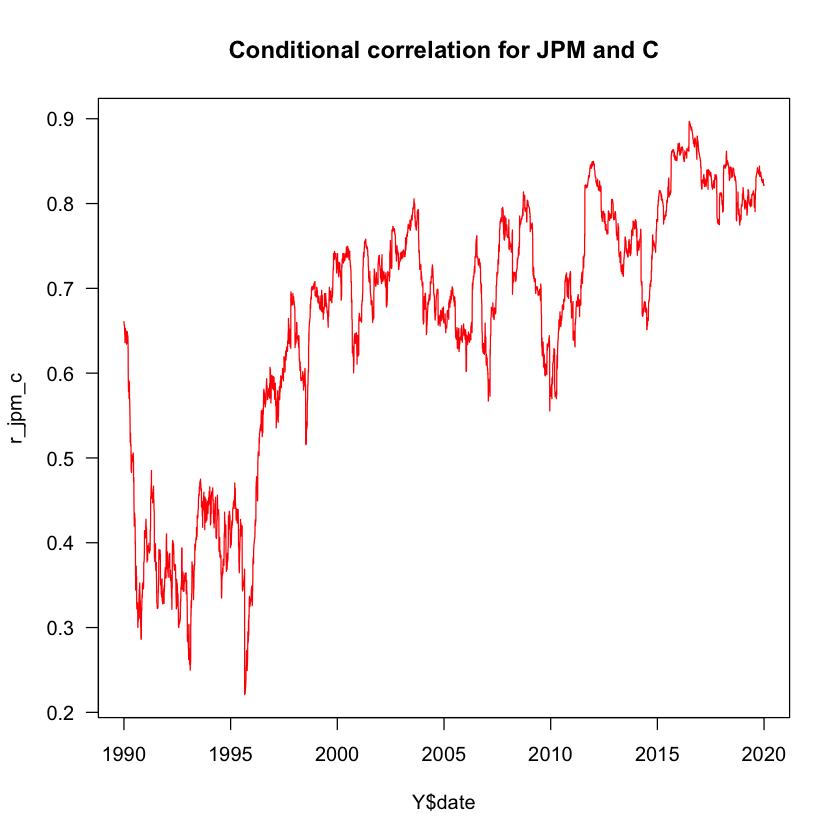

In [49]:
# JPM and C
r_jpm_c <- cond_corr("JPM", "C")

# Plot it
plot(Y$date, r_jpm_c, main = "Conditional correlation for JPM and C",
     type = "l", col = "red", las = 1)

Add a horizontal line at the mean:

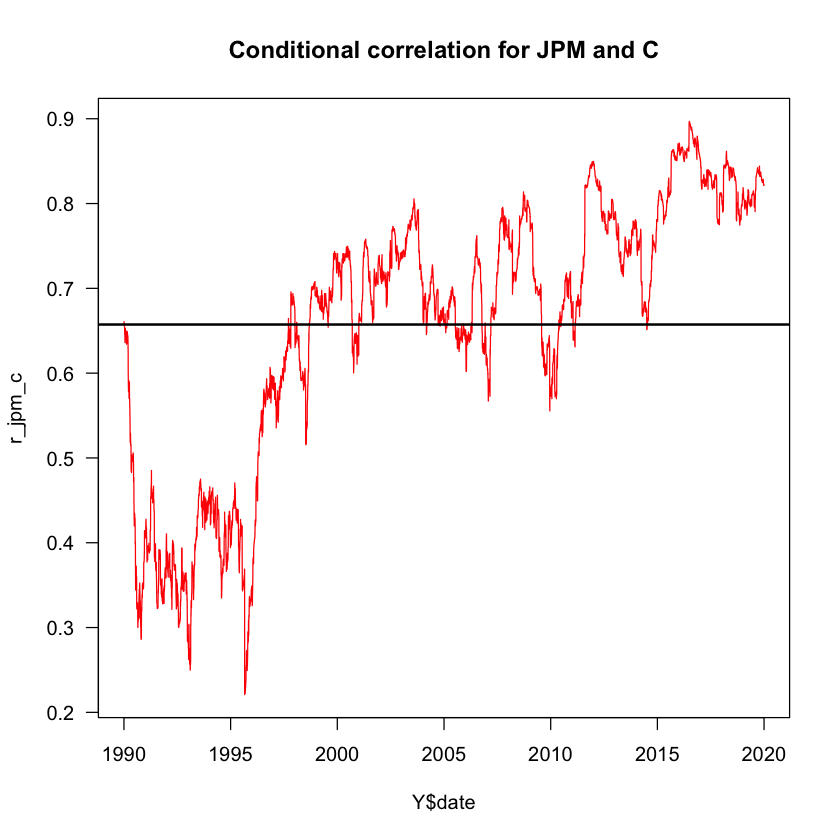

In [50]:
# Horizontal line at mean
plot(Y$date, r_jpm_c, main = "Conditional correlation for JPM and C",
     type = "l", col = "red", las = 1)
abline(h = mean(r_jpm_c), lwd = 2)

___
<a name="4"></a>
## Model comparison

In this section we will compare both visually and numerically the output of the models we have ran. We will focus in comparing the EWMA and DCC models.

### Plotting the Conditional Correlations

Let's use `matplot()` to plot the conditional correlations obtained in EWMA, DCC, and the DCC using apARCH:

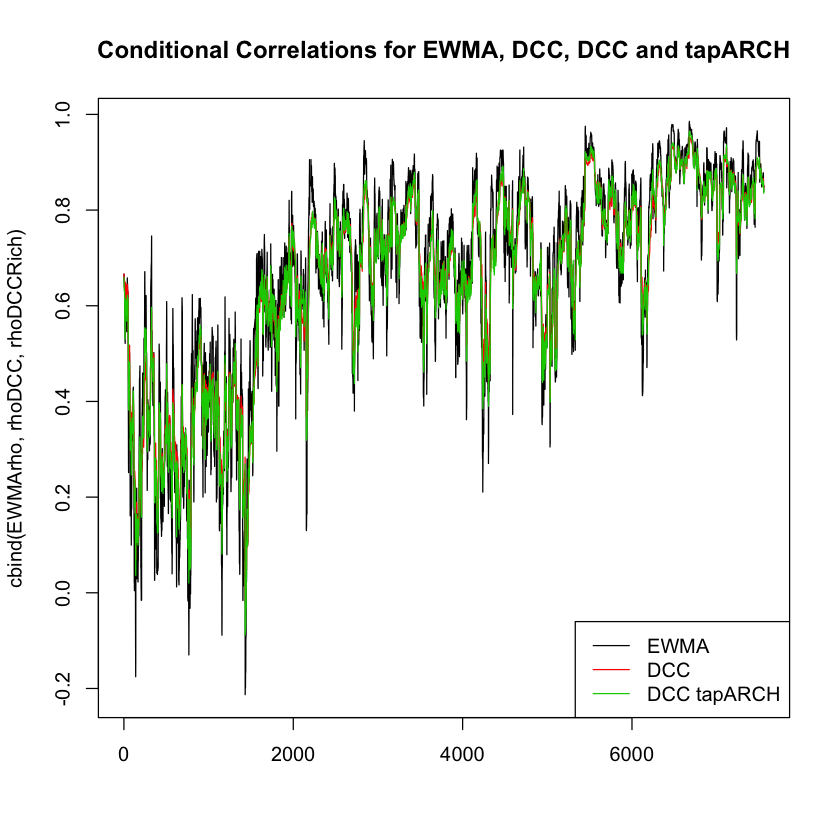

In [51]:
# Comparing DCC and EWMA visually
matplot(cbind(EWMArho, rhoDCC, rhoDCCRich), type = "l", lty = 1,
       main = "Conditional Correlations for EWMA, DCC, DCC and tapARCH")
legend("bottomright", legend = c("EWMA", "DCC", "DCC tapARCH"), lty = 1, col = 1:3)

We can see the estimations are quite similar. Computing the correlation between the conditional correlations of the three methods shows us a near-perfect correlation:

In [52]:
# Correlation
cor(cbind(EWMArho, rhoDCC, rhoDCCRich))

,EWMArho,rhoDCC,rhoDCCRich
EWMArho,1.0000000,0.9688303,0.9777499
rhoDCC,0.9688303,1.0000000,0.9973558
rhoDCCRich,0.9777499,0.9973558,1.0000000


We see a strong linear relationship between `EWMArho` and `rhoDCC`:

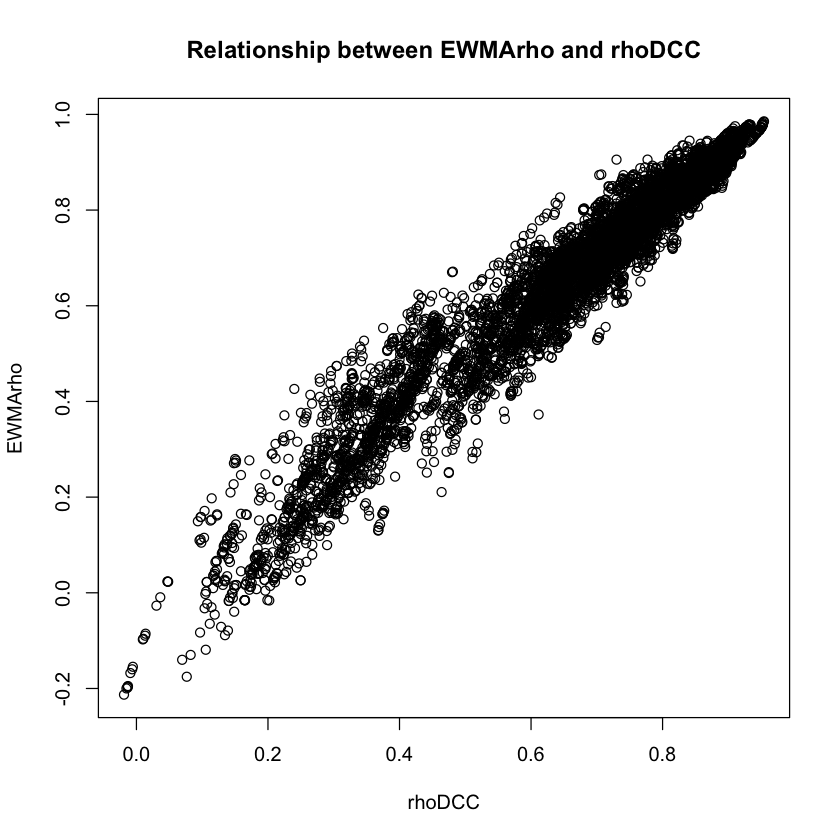

In [53]:
# Relationship between EWMArho and rhoDCC
plot(rhoDCC, EWMArho, main = "Relationship between EWMArho and rhoDCC")

Let's use `colMeans()` to obtain the mean of each series:

In [54]:
# Mean of each
colMeans(cbind(EWMArho, rhoDCC, rhoDCCRich))

# Standard deviation of each
sd(EWMArho)
sd(rhoDCC)
sd(rhoDCCRich)

EWMArho     rhoDCC rhoDCCRich 
 0.6621703  0.6581777  0.6537902

[1] 0.2209711

[1] 0.1950705

[1] 0.2024928

The mean of the conditional correlation for the three models is very similar. We see that the EWMA model presents the largest variability.

Now we plot only the EWMA and standard DCC models:

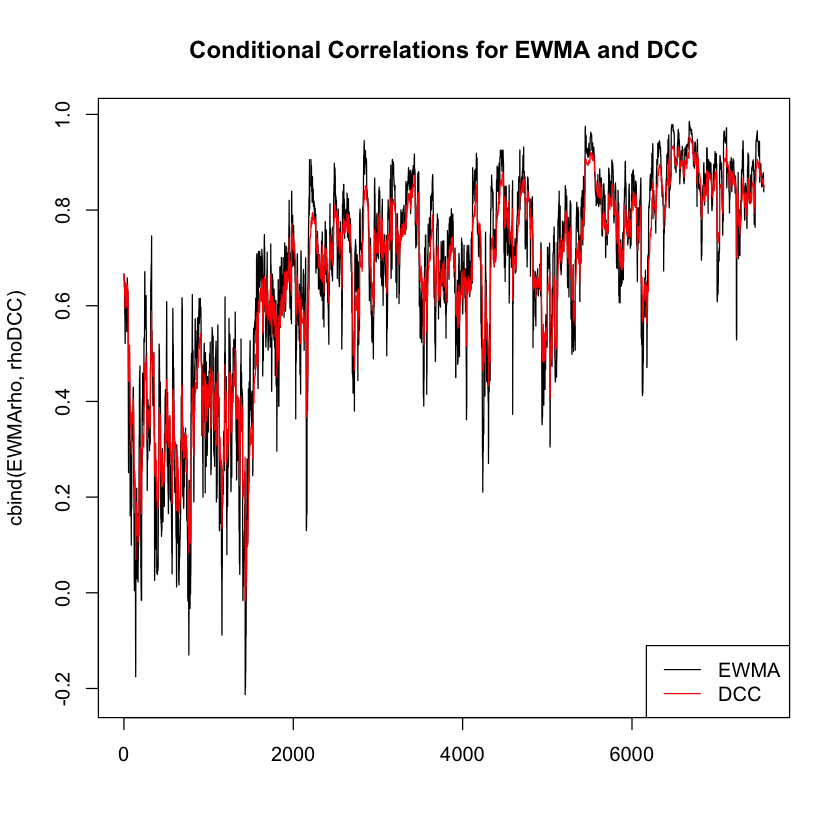

In [55]:
# EWMA and standard DCC
matplot(cbind(EWMArho, rhoDCC), type = "l", lty = 1,
       main = "Conditional Correlations for EWMA and DCC")
legend("bottomright", legend = c("EWMA", "DCC"), lty = 1, col = 1:2)

## Recap

In this seminar we have covered:

* Multivariate volatility modelling in R
* Implementing an EWMA model 
* Extracting and plotting conditional variances, covariances, and correlations for EWMA
* Fitting different specifications of DCC models
* Extracting and plotting conditional variances, covariances, and correlations for DCC
* Benchmarking for loops vs vector operations
* Performing Likelihood Ratio tests for DCC models
* Demonstrating an implementation of GOGARCH
* Comparing and plotting models

Some new functions used:

* `cov()`
* `upper.tri()`
* `multispec()`
* `dccspec()`
* `dccfit()`
* `gogarch()`
* `gogarchfit()`

For more discussion on the material covered in this seminar, refer to _Chapter 3: Multivariate volatility modeling_ on _Financial Risk Forecasting_ by Jon Danielsson.

<small> Acknowledgements: Thanks to Alvaro Aguirre for creating these notebooks</small>  
<small> © Jon Danielsson, 2020 </small>